# 1. Veri Toplama

## 1.1. Kütüphanelerin içe Aktarılması

In [1]:
import requests
import pandas as pd
from datetime import timedelta
from sklearn.metrics import accuracy_score
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## 1.2. EPİAŞ'tan Veri Çekme

EPİAŞ API servisi kullanılarak belirtilen tarih aralığındaki verilerin çekilmesi.

In [2]:
url = "https://seffaflik.epias.com.tr/transparency/service/market/smp?endDate=2022-12-31&startDate=2022-01-01"
response = requests.get(url)
data = response.json()



## 1.3. Veriyi Pandas DataFrame'e Dönüştürme

Çeşitli ön işlemelerin yapılması için verinin pandas DataFrame formatına dönüştürülmesi.

In [3]:
smp_list = data['body']["smpList"]
df = pd.DataFrame(smp_list)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M")

In [4]:
df.head()

,date,price,smpDirection,smpDirectionId,nextHour
0,2022-01-01 00:00:00+03:00,525.00,YAT,3,2022-01-01T01:00:00.000+0300
1,2022-01-01 01:00:00+03:00,848.01,YAL,1,2022-01-01T02:00:00.000+0300
2,2022-01-01 02:00:00+03:00,990.00,YAL,1,2022-01-01T03:00:00.000+0300
3,2022-01-01 03:00:00+03:00,500.00,YAT,3,2022-01-01T04:00:00.000+0300
4,2022-01-01 04:00:00+03:00,500.00,YAT,3,2022-01-01T05:00:00.000+0300


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype                                
---  ------          --------------  -----                                
 0   date            8760 non-null   datetime64[ns, pytz.FixedOffset(180)]
 1   price           8760 non-null   float64                              
 2   smpDirection    8760 non-null   object                               
 3   smpDirectionId  8760 non-null   int64                                
 4   nextHour        8760 non-null   object                               
dtypes: datetime64[ns, pytz.FixedOffset(180)](1), float64(1), int64(1), object(2)
memory usage: 342.3+ KB


In [6]:
df.describe()

,price,smpDirectionId
count,8760.000000,8760.000000
mean,2548.647017,1.389269
std,1269.177221,0.779093
min,0.000000,1.000000
25%,1524.000000,1.000000
50%,2450.000000,1.000000
75%,3503.000000,1.000000
max,4800.000000,3.000000


In [7]:
df.isna().sum()

date              0
price             0
smpDirection      0
smpDirectionId    0
nextHour          0
dtype: int64

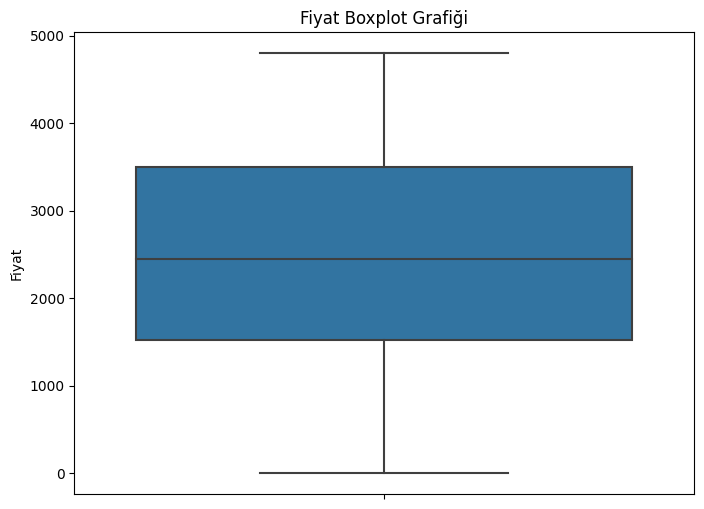

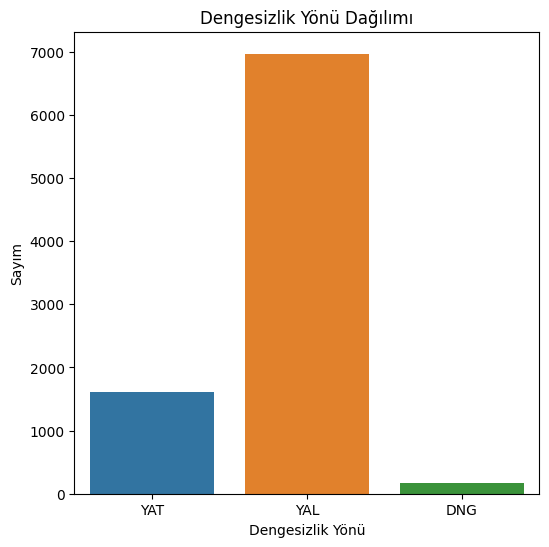

In [8]:
# 3. Boxplot Grafiği
plt.figure(figsize=(8, 6))
sns.boxplot(y='price', data=df)
plt.ylabel('Fiyat')
plt.title('Fiyat Boxplot Grafiği')
plt.show()


# Dengesizlik Yönü Dağılımı
plt.figure(figsize=(6, 6))
sns.countplot(x="smpDirection", data=df)
plt.title("Dengesizlik Yönü Dağılımı")
plt.xlabel("Dengesizlik Yönü")
plt.ylabel("Sayım")
plt.show()


##### Fiyat Dağılımı

Fiyatların boxplot grafiği, fiyatların dağılımının normal olduğunu göstermektedir. Ayrıca aykırı değerlerin olmadığını da görebiliyoruz.
##### Dengesizlik Yönü Dağılımı

Dengesizlik yönü dağılımı grafiği, YAL dengesizlik yönünün en yaygın olduğunu, YAT'ın daha az yaygın olduğunu ve DNG sınıfının ise çok nadir olduğunu göstermektedir.

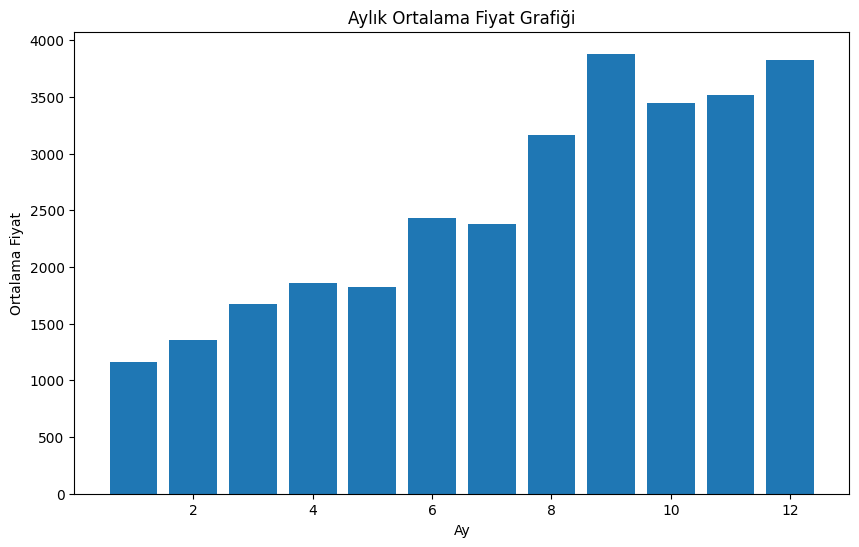

In [9]:
# 4. Aylık Ortalama Fiyat Grafiği
df['month'] = df['date'].dt.month
monthly_average_prices = df.groupby('month')['price'].mean()

plt.figure(figsize=(10, 6))
plt.bar(monthly_average_prices.index, monthly_average_prices.values)
plt.xlabel('Ay')
plt.ylabel('Ortalama Fiyat')
plt.title('Aylık Ortalama Fiyat Grafiği')
plt.show()


2022 yılında aylık bazda zamana göre fiyatların ortalamasında artış olduğunu söyleyebiliriz.

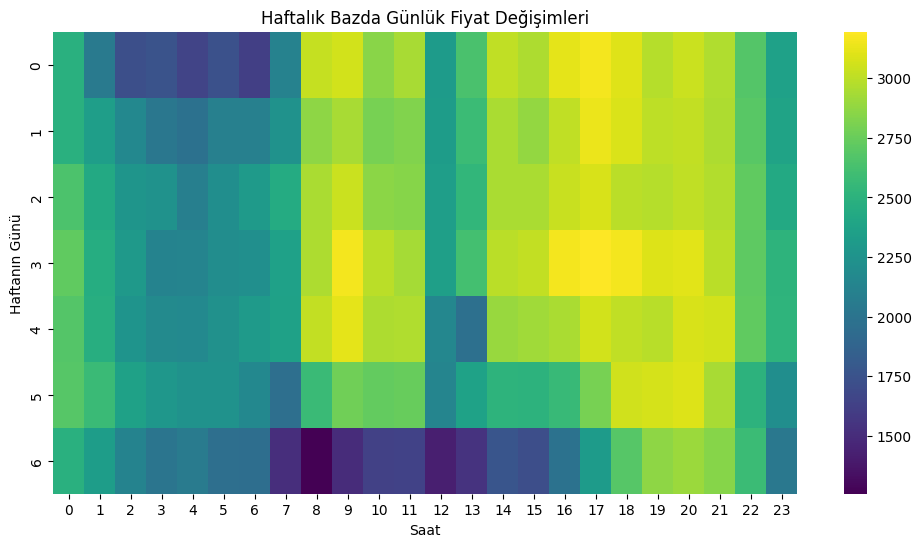

In [10]:
# 5. Haftalık ve Günlük Fiyat Değişimleri
df['weekday'] = df['date'].dt.weekday
df['hour'] = df['date'].dt.hour
weekly_avg_prices = df.groupby(['weekday', 'hour'])['price'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(weekly_avg_prices, cmap='viridis', annot=False, fmt='.2f')
plt.xlabel('Saat')
plt.ylabel('Haftanın Günü')
plt.title('Haftalık Bazda Günlük Fiyat Değişimleri')
plt.show()

Yukarıdaki sıcaklık grafiğine göre haftanın günleri bazında gün doğumundan sonra 8-9-10-11 saatlerinde bir fiyat artışı gözlenmektedir. 12 ve 13te düşüş ve sonra gece saatlerine kadar bir fiyat artışı gözlemlenmiştir

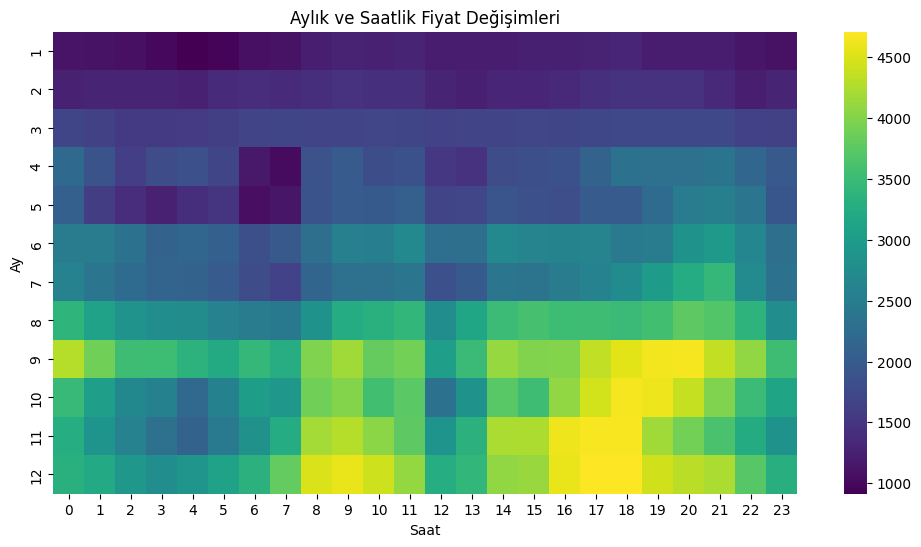

In [11]:
# 6. Isı Haritası (örnek olarak aylık ve saatlik veriler için)
monthly_hourly_avg_prices = df.groupby(['month', 'hour'])['price'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_hourly_avg_prices, cmap='viridis', annot=False, fmt='.2f')
plt.xlabel('Saat')
plt.ylabel('Ay')
plt.title('Aylık ve Saatlik Fiyat Değişimleri')
plt.show()

Fiyatların en yüksek değerine ulaştığı zamanı 9,10,11,12. aylar olarak söyleyebiliriz.

# 2. Sezgisel Kuralın Performansının Değerlendirilmesi

# 2.1. Sezgisel Kural Uygulanması

Sezgisel kural uygulanarak dengesizlik yönünün tahmin edilmesi

In [12]:
df["predicted_smp_direction"] = df["smpDirection"].shift(3)
df = df.dropna() # Lag alındıktan sonra ilk üç veri hesaplanamayacağı için ve aynı zamanda metrik sonucunu etkileyeceği için düşürülmüştür.

## 2.2. Performans Metriklerinin Hesaplanması

Sezgisel kuralın performansının hesaplanması için doğruluk (accuracy) metriği kullanılmıştır.

In [13]:
accuracy = (df["smpDirection"] == df["predicted_smp_direction"]).mean()
print(f"Sezgisel kuralın performansı: {accuracy:.2%}")


Sezgisel kuralın performansı: 79.76%


### 2.3. Saatlik ve Aylık Performans Analizi

Saatlik ve aylık performansı analiz etmek için, saat ve ay sütunları oluşturulmuş ve doğrulukları hesaplanmıştır.

In [14]:
df["hour"] = df["date"].dt.hour
df["month"] = df["date"].dt.month

hourly_accuracy = df.groupby("hour").apply(lambda x: (x["smpDirection"] == x["predicted_smp_direction"]).mean())
monthly_hourly_accuracy = df.groupby(["month", "hour"]).apply(lambda x: (x["smpDirection"] == x["predicted_smp_direction"]).mean())

print("Saatlik performans:")
print(hourly_accuracy)

print("\nAylık bazda saatlik performans:")
print(monthly_hourly_accuracy.unstack())


Saatlik performans:
hour
0     0.788462
1     0.760989
2     0.752747
3     0.767123
4     0.813699
5     0.830137
6     0.742466
7     0.739726
8     0.761644
9     0.736986
10    0.794521
11    0.832877
12    0.772603
13    0.810959
14    0.860274
15    0.830137
16    0.800000
17    0.865753
18    0.827397
19    0.819178
20    0.849315
21    0.830137
22    0.775342
23    0.780822
dtype: float64

Aylık bazda saatlik performans:
hour         0         1         2         3         4         5         6   \
month                                                                         
1      0.933333  0.900000  0.900000  0.774194  0.741935  0.774194  0.709677   
2      0.821429  0.607143  0.785714  0.785714  0.892857  0.857143  0.714286   
3      0.838710  0.806452  0.774194  0.903226  0.967742  0.935484  0.870968   
4      0.800000  0.800000  0.700000  0.866667  0.800000  0.800000  0.533333   
5      0.677419  0.548387  0.612903  0.612903  0.903226  0.838710  0.838710   
6      0.76666

- Sezgisel kuralın genel performansı: %79.76
- Özellikle saatlik ve aylık performans analizlerinde, sezgisel kuralın bazı saatlerde ve aylarda daha iyi performans gösterdiği görülüyor. Bu, kuralın belirli durumlar için daha uygun olduğunu düşündürebilir.

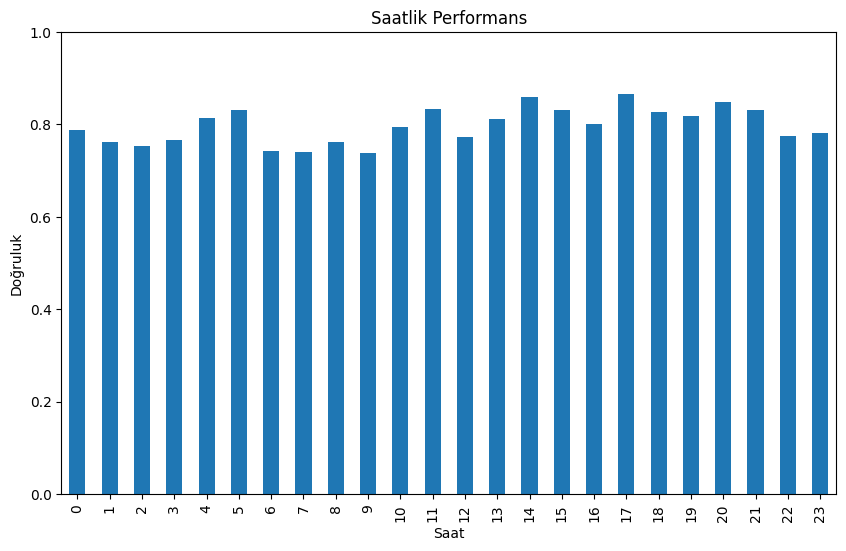

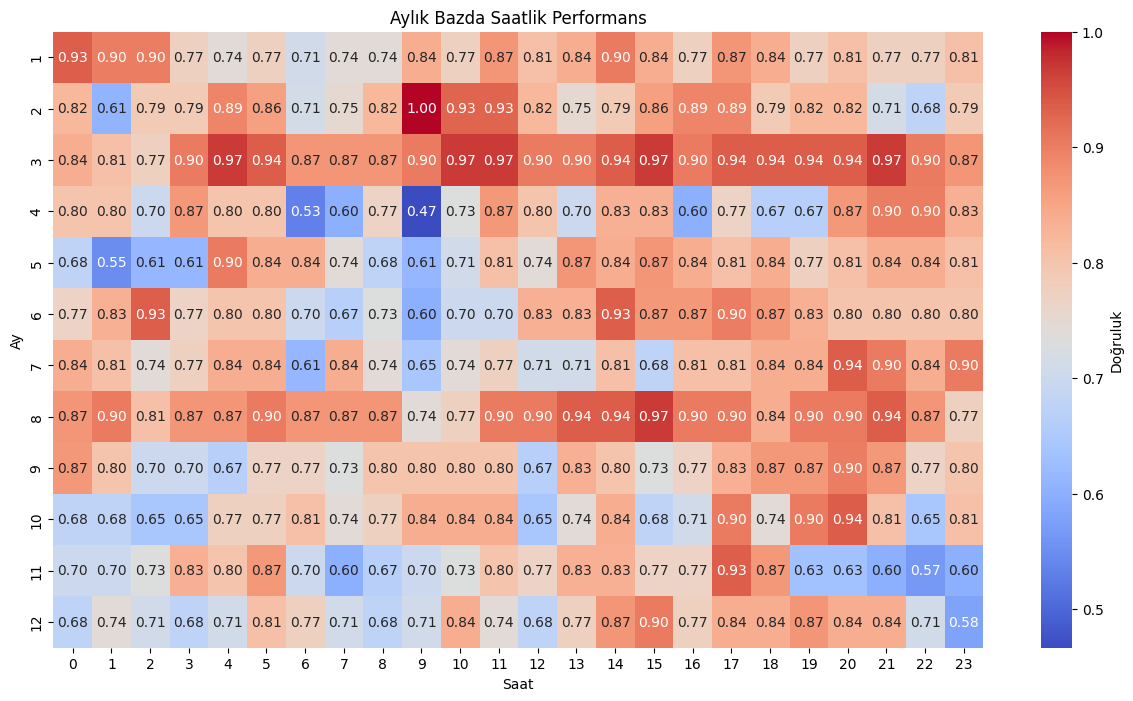

In [15]:
# Saatlik performans
plt.figure(figsize=(10, 6))
hourly_accuracy.plot(kind="bar")
plt.title("Saatlik Performans")
plt.xlabel("Saat")
plt.ylabel("Doğruluk")
plt.ylim(0, 1)
plt.show()

# Aylık bazda saatlik performans
plt.figure(figsize=(15, 8))
sns.heatmap(monthly_hourly_accuracy.unstack(), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Doğruluk"})
plt.title("Aylık Bazda Saatlik Performans")
plt.xlabel("Saat")
plt.ylabel("Ay")
plt.show()



##### Saatlik Performans

Sezgisel kuralın saatlik performansı grafiği, kuralın bazı saatlerde daha iyi performans gösterdiğini göstermektedir. Özellikle, saat 17'de en yüksek doğruluk oranına (%86.6) ulaşılırken, saat 9'da en düşük doğruluk oranıyla (%73.7) karşılaşılmaktadır. Bu, enerji talebinin ve arzının belirli saatlerde daha öngörülebilir olduğunu ve kuralın bu saatlerde daha başarılı olduğunu gösteriyor olabilir

##### Aylık Bazda Saatlik Performansın

Aylık bazda saatlik performansın ısı haritası, sezgisel kuralın belirli aylarda ve saatlerde nasıl performans gösterdiğini göstermektedir. Özellikle, 2. ayın saat 9'unda %100 doğruluk elde edilirken, 3. ayda ortalama olarak çok iyi tahminler yapılmış ve neredeyse hepsi %90 üzerinde doğruluk sağlanmıştır. Bununla birlikte, 4. ay, sezgisel kuralın en kötü performans gösterdiği dönemdir; özellikle saat 9'da %47 doğruluk elde edilmiştir. Bu bulgular, enerji talebi ve arzının belirli aylar ve saatlerde daha öngörülebilir olduğunu gösteriyor olabilir ve bu durum, sezgisel kuralın başarısını etkileyebilir.

# 3. İleri Dönemler İçin Dengesizlik Yönü Tahmini

## 3.1. EPİAŞ'tan "DGP Talimat REST Servisi" Verilerini Çekme

EPİAŞ'tan "DGP Talimat REST SERVİSİ" verilerini çekmek için, gerekli parametreler ve request URL'si belirlenmiş.

#### Parametreler

- Bu problem için start_date 2018-01-01, end_date 2022-12-31 olarak belirlenmiştir.
- Model, sezgisel kural ile kıyaslanacağı için 2022 yılı test veri kümesi olacaktır.
- 2021 validasyon veri kümesi olacak ve 2021den önceki veri eğitim veri seti olacaktır.
- %60 eğitim, %20 validasyon ve %20 test.

In [16]:
base_url = "https://seffaflik.epias.com.tr/transparency/service/market/bpm-order-summary"
start_date = "2018-01-01"
end_date = "2022-12-31"

params = {
    "startDate": start_date,
    "endDate": end_date
}

dgp_response = requests.get(base_url, params=params)
dgp_data = dgp_response.json()


## 3.2. Veriyi Pandas DataFrame'e Dönüştürme

In [18]:
# 'bpmOrderSummaryList' anahtarını kullanarak ilgili bilgileri elde edin
dgp_list = dgp_data['body']["bpmOrderSummaryList"]

# Tüm saatler için ilgili verileri içeren bir DataFrame oluşturun
hour_data = []

for hour_info in dgp_list:
    hour_info["tarih"] = pd.to_datetime(hour_info["date"], format="%Y-%m-%dT%H:%M:%S.%f%z")
    hour_data.append(hour_info)

# Tüm saatlerin verilerini içeren tek bir DataFrame oluşturun
dgp_df = pd.DataFrame(hour_data)


## 3.3. Özellik Çıkarımı

In [19]:
# Geçmiş saatlerdeki verilere dayalı özellikler eklemek için 'shift' fonksiyonunun kullanılması

dgp_df["target_direction"] = dgp_df["direction"].shift(-3)

# Tarihle ilgili özelliklerin eklenmesi
dgp_df["month"] = dgp_df["tarih"].dt.month
dgp_df["day"] = dgp_df["tarih"].dt.day
dgp_df["hour"] = dgp_df["tarih"].dt.hour
dgp_df["weekday"] = dgp_df["tarih"].dt.weekday

dgp_df = dgp_df.dropna()

# Gün başlangıçlarının belirlenmesi
dgp_df['day_start'] = dgp_df['hour'] == 0

# Kümülatif ortalama sütununun tanımlanması
dgp_df['cumulative_avg'] = 0.0

# Günlerin başlangıçlarının alınması
day_starts = dgp_df[dgp_df['day_start']].index.tolist()

# Her günün kümülatif ortalamasını hesaplama
for i in range(len(day_starts)):
    start = day_starts[i]
    if i < len(day_starts) - 1:
        end = day_starts[i + 1]
    else:
        end = len(dgp_df)
    cum_sum = 0
    count = 0
    for j in range(start, end):
        cum_sum += dgp_df.loc[j, 'net']
        count += 1
        dgp_df.loc[j, 'cumulative_avg'] = cum_sum / count



cumulative_avg değişkeni eklenmiştir. Bu değişken, her günün başlangıcından itibaren saatlik net değerlerin kümülatif ortalamasını temsil eder. Bu özellik, modelin dengesizlik yönü tahmininde bulunurken gün içindeki trendler ve patternler hakkında bilgi edinmesine yardımcı olur.

## 3.4. Modelin Eğitimi ve Tahminlerin Yapılması

#### 3.4.1 PyCaret

PyCaret, Python’da makine öğrenimi iş akışlarını otomatikleştiren açık kaynaklı, düşük kodlu bir makine öğrenimi kütüphanesidir. PyCaret ile makine öğrenimi modellerini eğitmek, değerlendirmek, karşılaştırmak, optimize etmek ve dağıtmak için yüzlerce satır kod yerine sadece birkaç satır kod yazılabilir.

PyCaret’in avantajları şunlardır:

- Hızlı ve kolay kurulum. PyCaret pip veya conda ile yüklenebilir veya Docker ile çalıştırılabilir.

- Modüler ve tutarlı tasarım. PyCaret, belirli makine öğrenimi görevlerini kapsayan modüllerden oluşur. Her modüldeki fonksiyonlar birbiriyle uyumludur ve diğer modüllerle de çalışabilir.

- Veri ön işleme ve özellik mühendisliği desteği. PyCaret, verileri ölçeklendirmek, dönüştürmek, eksik değerleri doldurmak, kategorik değişkenleri kodlamak, aykırı değerleri tespit etmek ve gidermek gibi birçok veri ön işleme işlevi sunar. Ayrıca, verilerden yeni özellikler türetmek için PCA, RFE ve diğer yöntemleri de kullanabilir.

- Çoklu model eğitimi ve karşılaştırma. PyCaret, bir veri seti üzerinde birden fazla modelin otomatik olarak eğitilmesine ve performanslarının çeşitli metriklerle karşılaştırılmasına olanak tanır. Bu şekilde en uygun modeli seçilebilir.
- Model optimizasyonu ve seçimi. PyCaret, model hiperparametrelerini optimize etmek için ızgara araması (GridSearch) veya rastgele arama (RandomSearch) gibi yöntemleri kullanabilir. Ayrıca, model seçimi için çapraz doğrulama veya katmanlı doğrulama gibi teknikleri de uygulayabilirsiniz1.
- Model açıklaması ve yorumlanması. PyCaret, eğitilmiş modellerin nasıl çalıştığını anlamak için çeşitli araçlar sunar. Örneğin, ROC eğrisi, hassasiyet-duyarlılık eğrisi, karışıklık matrisi gibi performans göstergelerini gösterebilir. Ayrıca, SHAP gibi kütüphaneleri kullanarak modelin tahminlerini açıklayabilir veya etkileşimli olarak görselleştirilebilir.
- Model dağıtımı ve izlenmesi. PyCaret, eğitilmiş modellerin REST API olarak dağıtılmasına veya basit bir web uygulaması oluşturulmasına olanak tanır. Ayrıca, model AWS veya Azure gibi bulut platformlara dağıtılabilir veya MLflow gibi araçlarla izlenebilir.

In [22]:
from pycaret.classification import *

In [23]:
valid_data = dgp_df[(dgp_df['date']<'2022') & (dgp_df['date']>'2021')]
test_data = dgp_df[(dgp_df['date']>'2022')]
train_data = dgp_df[(dgp_df['date']<'2021')]

In [24]:
clf = setup(data=train_data,
            test_data=valid_data,
            data_split_shuffle=False,
            data_split_stratify= False,
            fold_strategy="timeseries",
            target="target_direction",
            ignore_features=["tarih", "date", "nextHour"],
            categorical_features=["weekday"],
            preprocess=True, # Özellik dönüşümünü ve ölçeklendirmeyi devre dışı bırakın
            verbose=True)

,Description,Value
0,Session id,5733
1,Target,target_direction
2,Target type,Multiclass
3,Target mapping,"ENERGY_DEFICIT: 0, ENERGY_SURPLUS: 1, IN_BALANCE: 2"
4,Original data shape,"(35064, 20)"
5,Transformed data shape,"(35064, 23)"
6,Transformed train set shape,"(26304, 23)"
7,Transformed test set shape,"(8760, 23)"
8,Ignore features,3
9,Numeric features,13



- "data" parametresi, eğitim veri kümesini belirtir.

- "test_data" parametresi, doğrulama veri kümesini belirtir.

- "data_split_shuffle" parametresi, verilerin karıştırılıp karıştırılmayacağını belirtir.

- "data_split_stratify" parametresi, verilerin ayrıştırılırken oranlarına dikkat edilip edilmeyeceğini belirtir.

- "fold_strategy" parametresi, çapraz doğrulama yöntemini belirtir. Bu örnekte, "timeseries" olarak belirtilmiştir, bu da zaman serisi tabanlı bir çapraz doğrulama yapılacağı anlamına gelir.

- "target" parametresi, hedef değişkeni belirtir.

- "ignore_features" parametresi, model eğitimi için kullanılmayacak özellikleri belirtir.

- "categorical_features" parametresi, kategorik özellikleri belirtir.

- "preprocess" parametresi, özellik dönüşümlerini ve ölçeklendirmeleri etkinleştirir veya devre dışı bırakır.

- "verbose" parametresi, işlem sırasında ayrıntılı çıktı verir.

In [25]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7200,0.8036,0.7200,0.6984,0.7001,0.4179,0.4274,3.6960
dummy,Dummy Classifier,0.5737,0.5000,0.5737,0.3338,0.4207,0.0000,0.0000,3.4970


In [26]:
tuned_model = tune_model(best_model,optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7327,0.8159,0.7327,0.6957,0.7118,0.4187,0.4247
1,0.7578,0.8338,0.7578,0.7167,0.7242,0.3955,0.4230
2,0.7327,0.8122,0.7327,0.7027,0.7129,0.4547,0.4635
3,0.7256,0.7945,0.7256,0.7014,0.7110,0.4449,0.4493
4,0.7503,0.8310,0.7503,0.7330,0.7358,0.4943,0.5037
5,0.7014,0.8026,0.7014,0.6551,0.6712,0.4016,0.4150
6,0.6713,0.7719,0.6713,0.6353,0.6511,0.3652,0.3694
7,0.7311,0.8266,0.7311,0.6968,0.7131,0.4867,0.4893
8,0.8080,0.8775,0.8080,0.7729,0.7889,0.5370,0.5433


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [27]:
f = finalize_model(tuned_model)

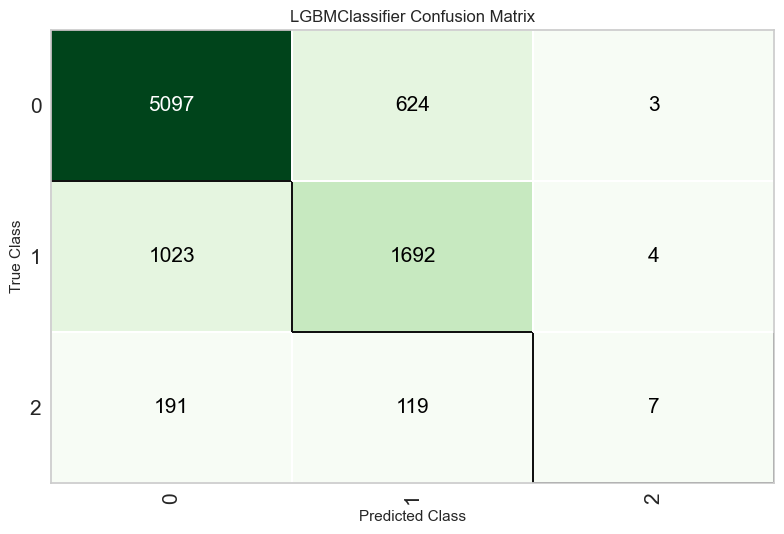

In [28]:
plot_model(f,plot='confusion_matrix')

In [29]:
predictions = predict_model(f, data=test_data)
accuracy = accuracy_score(predictions['target_direction'], predictions['prediction_label'])
print("Accuracy: {:.2f}%".format(accuracy * 100))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8243,0.8049,0,0,0,0.4147,0.4200


Accuracy: 82.43%


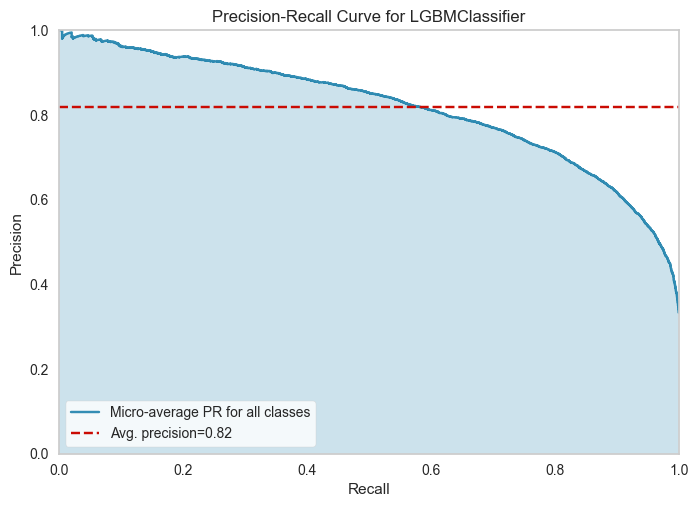

In [30]:
plot_model(f,plot="pr")

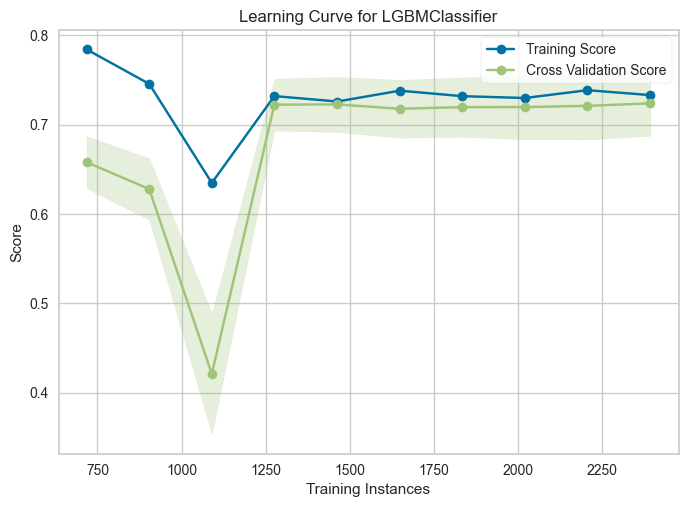

In [31]:
plot_model(tuned_model,plot="learning",use_train_data=False)

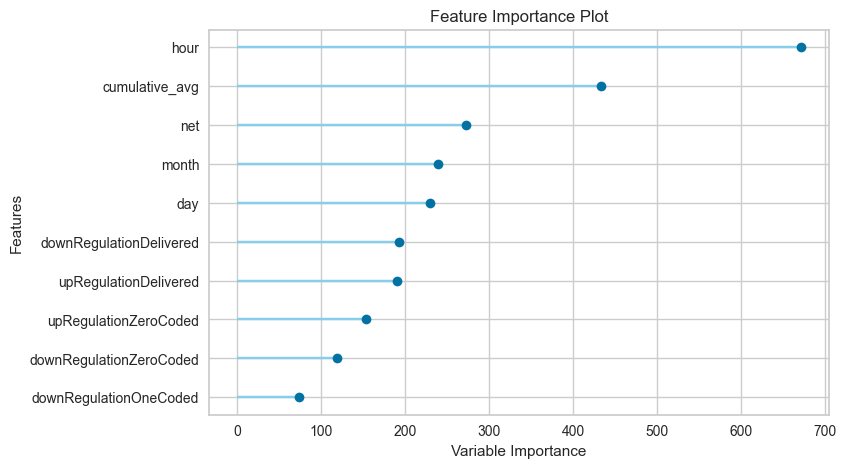

In [32]:
plot_model(f,plot="feature",use_train_data=False)

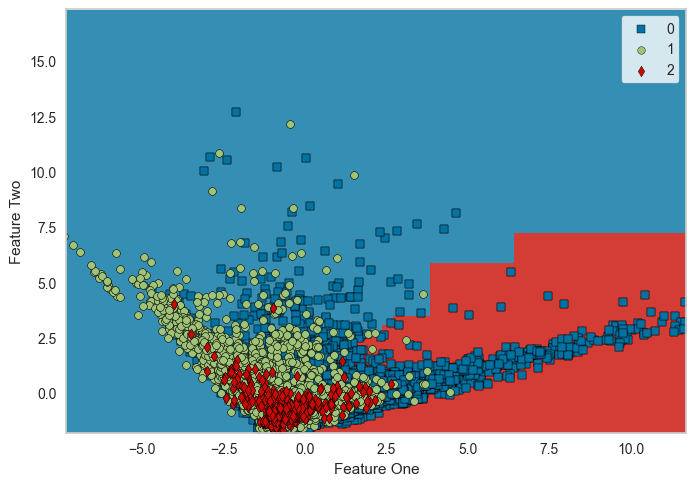

In [33]:
plot_model(f,plot="boundary",use_train_data=False)

In [41]:
def yuzdeler(model, df, prediction_label, y):
    preds = predict_model(model, df)[[y, 'prediction_label', 'prediction_score']]
    son = pd.DataFrame()
    preds = preds[preds['prediction_label']==prediction_label]
    arange = np.arange(0.5, 1, 0.005)
    for i in arange:
        deneme = preds[preds['prediction_score']>=i]
        yuzde = round(accuracy_score(deneme[y], deneme['prediction_label']), 3)
        dicto = {'Thresh': i, 'Yüzde': yuzde, 'Len': len(deneme)}
        son = son.append(pd.DataFrame(dicto, index=[0]), ignore_index=True)
        son = son.dropna(axis=0)
    #son.to_csv(f"precs/{y}model_{prediction_label}.csv", index=False)
    return son.sort_values('Thresh', ascending=False)


In [42]:
predict_model(f, test_data)[["target_direction", 'prediction_label', 'prediction_score']]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8243,0.8049,0,0,0,0.4147,0.4200


,target_direction,prediction_label,prediction_score
35064,ENERGY_SURPLUS,ENERGY_SURPLUS,0.4907
35065,ENERGY_SURPLUS,ENERGY_DEFICIT,0.6263
35066,ENERGY_SURPLUS,ENERGY_DEFICIT,0.6466
35067,ENERGY_SURPLUS,ENERGY_SURPLUS,0.6069
35068,ENERGY_SURPLUS,ENERGY_SURPLUS,0.5794
...,...,...,...
43816,ENERGY_DEFICIT,ENERGY_DEFICIT,0.7068
43817,ENERGY_DEFICIT,ENERGY_DEFICIT,0.5402
43818,ENERGY_SURPLUS,ENERGY_DEFICIT,0.8790
43819,ENERGY_SURPLUS,ENERGY_DEFICIT,0.8913


In [43]:
p = predict_model(f,data =test_data)

px =p[["date","target_direction",'prediction_label','prediction_score']]


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8243,0.8049,0,0,0,0.4147,0.4200


In [45]:
yuzdeler(f,test_data,"ENERGY_DEFICIT","target_direction").head(50)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8243,0.8049,0,0,0,0.4147,0.4200


,Thresh,Yüzde,Len
97,0.985,0.992,247
96,0.980,0.988,566
95,0.975,0.985,677
94,0.970,0.985,793
93,0.965,0.982,920
92,0.960,0.979,1102
91,0.955,0.972,1278
90,0.950,0.967,1435
89,0.945,0.963,1583
88,0.940,0.964,1727


## 3.4. Dış Verilerin Eklenmesi

In [ ]:
base_url = "https://seffaflik.epias.com.tr/transparency/service/market/bpm-order-summary"
start_date = "2018-01-01"
end_date = "2022-12-31"

params = {
    "startDate": start_date,
    "endDate": end_date
}

dgp_response = requests.get(base_url, params=params)
dgp_data = dgp_response.json()


In [46]:
import holidays

In [48]:
df = dgp_df.copy()
dfs = pd.read_html('http://www.bulanik.gov.tr/ulkemizde-kutlanan-onemli-gun-ve-haftalar')
i_days = pd.concat(dfs)
conv_months = {'Ocak':1,'Şubat':2,'Mart':3,'Nisan':4,'Mayıs':5,'Haziran':6,'Temmuz':7,'Ağustos':8,'Eylül':9,'Ekim':10,'Kasım':11,'Aralık':12}
i_days = i_days[i_days[0].str.contains('Günü')]
i_days=i_days[~i_days[1].str.contains('ilk')]
i_days = i_days[~i_days[1].str.contains('-')]
new_months = i_days[1].str.split(' ',expand=True)[1].replace(conv_months)

i_days['days'] = i_days[1].str.split(' ',expand=True)[0]
i_days['months'] = new_months

i_days['days']=i_days['days'].astype('int64')

df['Year'] = df['tarih'].dt.year
df['Month'] = df['tarih'].dt.strftime('%B')
df['Day'] = df['tarih'].dt.day
df['Day of Week'] = df['tarih'].dt.strftime('%A')
df['Day of Year'] = df['tarih'].dt.day_of_year
df['Series'] = np.arange(0,len(df))+1
df['decmonth'] = df['tarih'].dt.month


In [47]:


tr_holidays = holidays.TR()

df = df.reset_index()

holidays = np.zeros(len(df))

for i in range(len(holidays)):
    if df['tarih'].dt.date[i] in tr_holidays:
        holidays[i] = 1
        
df['Holidays'] = holidays

df['is_Weekend'] = np.where(((df['Day of Week']=='Saturday') | (df['Day of Week']=='Sunday')),1,0)

df['Holidays'] = df['Holidays'].astype('int').astype('category')
df['is_Weekend'] = df['is_Weekend'].astype('category')






KeyboardInterrupt: 

In [45]:
new_df = pd.merge(df, i_days,  how='left', left_on=['decmonth','Day'], right_on = ['months','days'])
new_df = new_df.drop([1,'months'],axis=1).rename(columns={0:'Important Days'})
new_df = pd.merge(new_df, sinavdf,  how='left', left_on=['decmonth','Day'], right_on = ['months','days'])
new_df['Important Days'] = new_df['Important Days'].fillna('-')


In [85]:
new_df.to_csv('extended_data.csv',index=False)

### 3.4.3 Hava Durumu ve Yağış Verisi

In [54]:
def scrape_table_from_url(url, type):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    table_html = str(soup.find_all('table'))
    if type == 'gunes':
        df = pd.read_html(table_html)[0]
    elif type == 'ruzgar':
        df = pd.read_html(table_html)[0]
    elif type == 'hidroelektrik':
        df = pd.read_html(table_html)[0]
    return df


url = 'https://www.enerjiatlasi.com/en-buyuk/gunes'
df_gunes = scrape_table_from_url(url, 'gunes')

url = 'https://www.enerjiatlasi.com/en-buyuk/ruzgar'
df_ruzgar = scrape_table_from_url(url, 'ruzgar')

url = 'https://www.enerjiatlasi.com/en-buyuk/hidroelektrik'
df_hidroelektrik = scrape_table_from_url(url, 'hidroelektrik')

df = pd.concat([df_ruzgar, df_hidroelektrik], ignore_index=True)


In [96]:
illist = df['İl'].unique().tolist()

In [67]:
from datetime import datetime
import datetime as dt
import json

In [114]:
jres['data']['weather'][i]['astronomy'][0]

{'sunrise': '06:38 AM',
 'sunset': '07:09 PM',
 'moonrise': '11:29 AM',
 'moonset': '02:38 AM',
 'moon_phase': 'First Quarter',
 'moon_illumination': '50'}

In [120]:
enddate

Timestamp('2023-03-05 20:38:31.304774')

In [119]:
startdate

datetime.datetime(2023, 3, 29, 20, 38, 31, 304774)

In [136]:
weather_df

,Manisa_avgtempC,Manisa_sunrise,Manisa_sunset,Manisa_windspeedKmph,Manisa_precipitation,İzmir_avgtempC,İzmir_sunrise,İzmir_sunset,İzmir_windspeedKmph,İzmir_precipitation,...,Bingöl_avgtempC,Bingöl_sunrise,Bingöl_sunset,Bingöl_windspeedKmph,Bingöl_precipitation,Antalya_avgtempC,Antalya_sunrise,Antalya_sunset,Antalya_windspeedKmph,Antalya_precipitation
date,,,,,,,,,,,,,,,,,,,,,
2018-01-06,8,08:28 AM,06:04 PM,4,0.0,9,08:29 AM,06:06 PM,4,0.0,...,-8,08:21 AM,06:16 PM,10,0.0,12,08:11 AM,05:56 PM,3,0.0
2018-01-07,10,08:28 AM,06:05 PM,5,0.0,11,08:29 AM,06:07 PM,8,0.0,...,-8,08:21 AM,06:17 PM,6,0.0,11,08:11 AM,05:57 PM,4,0.0
2018-01-08,11,08:28 AM,06:06 PM,3,0.0,12,08:29 AM,06:07 PM,4,0.0,...,0,08:21 AM,06:18 PM,3,0.0,12,08:11 AM,05:57 PM,5,0.0
2018-01-09,10,08:28 AM,06:07 PM,7,0.0,11,08:29 AM,06:08 PM,8,0.0,...,7,08:21 AM,06:19 PM,6,0.0,12,08:10 AM,05:58 PM,5,0.0
2018-01-10,10,08:28 AM,06:08 PM,6,0.0,11,08:28 AM,06:09 PM,8,0.0,...,8,08:21 AM,06:20 PM,10,0.0,12,08:10 AM,05:59 PM,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-01,14,06:56 AM,07:34 PM,13,0.0,14,06:57 AM,07:35 PM,43,0.0,...,21,07:00 AM,07:34 PM,37,0.0,14,06:44 AM,07:19 PM,12,0.0
2023-04-02,15,06:54 AM,07:35 PM,18,0.0,16,06:56 AM,07:36 PM,26,0.0,...,14,06:59 AM,07:35 PM,12,0.0,15,06:42 AM,07:20 PM,12,0.0
2023-04-03,17,06:53 AM,07:36 PM,37,0.0,16,06:54 AM,07:36 PM,53,0.0,...,14,06:57 AM,07:36 PM,15,0.0,16,06:41 AM,07:21 PM,14,0.0


In [148]:
weather_df = pd.DataFrame()
enddate = datetime.today()
startdate = 0
for j in range(1,64):
    citydf1 = pd.DataFrame()    
    startdate = enddate - dt.timedelta(days=30)
    startst = startdate.strftime('%Y-%m-%d')
    endst = enddate.strftime('%Y-%m-%d')
    for city in illist:
        citydf = pd.DataFrame()
        url = f'https://api.worldweatheronline.com/premium/v1/past-weather.ashx?date={startst}&enddate={endst}&key=7742a8f8a86a4d4ba2d165007230504&q={city},turkey&format=json'
        r = requests.get(url)
        jres = json.loads(r.text)


        try:
            for i in range(len(jres['data']['weather'])):

                my_dict = { 
                            f'{city}_date' : jres['data']['weather'][i]['date'] ,
                            f'{city}_avgtempC' :  jres['data']['weather'][i]['avgtempC'],
                            f'{city}_sunrise' :  jres['data']['weather'][i]['astronomy'][0]['sunrise'],
                            f'{city}_sunset' :  jres['data']['weather'][i]['astronomy'][0]['sunset'],
                            f'{city}_windspeedKmph':  jres['data']['weather'][i]['hourly'][5]['windspeedKmph'],
                            f'{city}_precipitation':  float(jres['data']['weather'][i]['totalSnow_cm']) + (float(jres['data']['weather'][i]['hourly'][5]['precipMM'])*10)


                            }
                #citydf=pd.concat([citydf,pd.DataFrame(my_dict,index=[i])
                citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
        except Exception as e:
            print(e)
            break

        citydf1 = pd.concat([citydf1,citydf],axis=1)
    weather_df = weather_df.append(citydf1)
    
    enddate = enddate - pd.DateOffset(months=1)
    
weather_df = weather_df.drop_duplicates()
# _date ile biten sütunları bul
date_columns = [col for col in weather_df.columns if col.endswith('_date') and col != 'İstanbul_date']

# istenmeyen sütunları düşür ve istanbul_date'i yeniden adlandır, ardından index olarak ata
weather_df = weather_df.drop(date_columns, axis=1).rename(columns={'İstanbul_date': 'date'}).set_index('date')
weather_df.index = pd.to_datetime(weather_df.index)
weather_df = weather_df.sort_index()
#df.to_csv('data/weather.csv')

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(

'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(

'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(

'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.appe

'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(

'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(my_dict,index=[i]))
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  citydf = citydf.append(pd.DataFrame(

'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'
'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)
C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


'weather'


C:\Users\Hakan\AppData\Local\Temp\ipykernel_14700\1804602563.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append(citydf1)


In [8]:
weather_df = pd.read_csv('weather_df')

In [218]:
import pandas as pd
import pytz

# weather_df veri çerçevesine yeni bir index oluştur
start_date = pd.Timestamp('2018-01-06', tz=pytz.FixedOffset(180))
weather_df.index = pd.date_range(start=start_date, periods=len(weather_df), freq='D')


In [219]:
cols_to_drop = [col for col in weather_df.columns if col.endswith('_sunset') or col.endswith('_sunrise')]
cols_to_drop = list(set(cols_to_drop) - {'Sivas_sunset', 'Sivas_sunrise'})
weather_df = weather_df.drop(cols_to_drop, axis=1)
weather_df = weather_df.rename(columns={'Sivas_sunset': 'sunset', 'Sivas_sunrise': 'sunrise'})


In [220]:
def time_to_minutes(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes

weather_df['sunrise_minutes'] = weather_df['sunrise'].str.extract(r'(\d{1,2}:\d{2})').apply(lambda x: time_to_minutes(x[0]), axis=1)
weather_df['sunset_minutes'] = weather_df['sunset'].str.extract(r'(\d{1,2}:\d{2})').apply(lambda x: time_to_minutes(x[0]), axis=1)


In [222]:
weather_df = weather_df.drop(['sunrise','sunset'],axis=1)

In [158]:
new_df = pd.read_csv('extended_data.csv')

In [164]:
new_df = new_df.drop_duplicates(subset='date').drop('index',axis=1)

In [181]:
new_df['date'] = pd.to_datetime(new_df['date'])

In [238]:

# Şimdi birleştirme işlemi gerçekleştirin
merged_df = pd.merge_asof(new_df, weather_df, left_on='date', right_index=True,allow_exact_matches=False)

In [239]:
merged_df = merged_df.dropna()

In [240]:
merged_df = merged_df.drop('Sınav',axis=1)

In [249]:
merged_df[['is_Weekend']]

,is_Weekend
121,1
122,1
123,1
124,1
125,1
...,...
49216,1
49217,1
49218,1
49219,1


In [241]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43700 entries, 121 to 49220
Data columns (total 84 columns):
 #   Column                        Non-Null Count  Dtype                                
---  ------                        --------------  -----                                
 0   date                          43700 non-null  datetime64[ns, pytz.FixedOffset(180)]
 1   net                           43700 non-null  float64                              
 2   upRegulationZeroCoded         43700 non-null  float64                              
 3   upRegulationOneCoded          43700 non-null  float64                              
 4   upRegulationTwoCoded          43700 non-null  float64                              
 5   downRegulationZeroCoded       43700 non-null  float64                              
 6   downRegulationOneCoded        43700 non-null  float64                              
 7   downRegulationTwoCoded        43700 non-null  float64                              

In [227]:
#merged_df.to_csv('merged_df.csv',index=False)

In [270]:
merged_df = pd.read_csv('merged_df.csv')

### Covid Flag

In [271]:
merged_df["covid_flag"] = np.where((merged_df["date"] >= "2020-03-11") & (merged_df["date"] <= "2022-05-31"), 1, 0)

## 3.4. Modelin Eğitimi ve Tahminlerin Yapılması

In [370]:
from pycaret.classification import *

In [371]:
merged_df['target_direction'].value_counts()

ENERGY_DEFICIT    27758
ENERGY_SURPLUS    14250
IN_BALANCE         1692
Name: target_direction, dtype: int64

In [326]:
import pandas as pd
import numpy as np

def remove_outliers_iqr(df, columns, year_col, month_col, multiplier=1.5):
    new_df = df.copy()
    for column in columns:
        for year in new_df[year_col].unique():
            for month in new_df[month_col].unique():
                mask = (new_df[year_col] == year) & (new_df[month_col] == month)
                data = new_df.loc[mask, column]
                Q1 = data.quantile(0.25)
                Q3 = data.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - multiplier * IQR
                upper_bound = Q3 + multiplier * IQR
                new_df = new_df.loc[~((new_df[column] > upper_bound) | (new_df[column] < lower_bound)) | ~mask]
    return new_df

from scipy import stats

def remove_outliers_zscore(df, columns, year_col, month_col, threshold=3):
    new_df = df.copy()
    for column in columns:
        for year in new_df[year_col].unique():
            for month in new_df[month_col].unique():
                mask = (new_df[year_col] == year) & (new_df[month_col] == month)
                data = new_df.loc[mask, column]
                z_scores = np.abs(stats.zscore(data))
                new_df = new_df.loc[~((z_scores > threshold) & mask)]
    return new_df

from scipy import stats

def impute_outliers_zscore(df, columns, year_col, month_col, threshold=3):
    new_df = df.copy()
    for column in columns:
        for year in new_df[year_col].unique():
            for month in new_df[month_col].unique():
                mask = (new_df[year_col] == year) & (new_df[month_col] == month)
                data = new_df.loc[mask, column]
                z_scores = np.abs(stats.zscore(data))
                outliers = (z_scores > threshold) & mask
                median = new_df.loc[mask, column].median()
                new_df.loc[outliers, column] = median
    return new_df


In [379]:
selected_columns = ['net'] + [col for col in merged_df.columns if col.endswith('_windspeedKmph') or col.endswith('_precipitation')]


In [399]:
cleaned_iqr = remove_outliers_iqr(merged_df, selected_columns, 'Year', 'month')
cleaned_zscore = remove_outliers_zscore(merged_df, selected_columns, 'Year', 'month')


In [400]:
cleaned_zscore

,date,net,upRegulationZeroCoded,upRegulationOneCoded,upRegulationTwoCoded,downRegulationZeroCoded,downRegulationOneCoded,downRegulationTwoCoded,upRegulationDelivered,downRegulationDelivered,...,Bingöl_windspeedKmph,Bingöl_precipitation,Antalya_avgtempC,Antalya_windspeedKmph,Antalya_precipitation,sunrise_minutes,sunset_minutes,covid_flag,day_start,cumulative_avg
0,2018-01-06 01:00:00+03:00,926.37,2183.70,0.0,0.0,0.00,0.0,705.0,1631.37,-705.00,...,10.0,0.0,12.0,3.0,0.0,473.0,323.0,0,False,0.000000
1,2018-01-06 02:00:00+03:00,658.06,1646.47,0.0,0.0,39.00,0.0,674.0,1371.06,-713.00,...,10.0,0.0,12.0,3.0,0.0,473.0,323.0,0,False,0.000000
2,2018-01-06 03:00:00+03:00,577.39,1395.98,0.0,91.5,0.00,0.0,565.0,1142.39,-565.00,...,10.0,0.0,12.0,3.0,0.0,473.0,323.0,0,False,0.000000
3,2018-01-06 04:00:00+03:00,937.64,1835.00,0.0,91.5,0.00,0.0,565.0,1502.64,-565.00,...,10.0,0.0,12.0,3.0,0.0,473.0,323.0,0,False,0.000000
4,2018-01-06 05:00:00+03:00,594.98,1475.00,0.0,91.5,0.00,0.0,565.0,1159.98,-565.00,...,10.0,0.0,12.0,3.0,0.0,473.0,323.0,0,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43695,2022-12-31 16:00:00+03:00,563.23,707.33,0.0,0.0,0.00,0.0,0.0,563.23,0.00,...,19.0,0.0,14.0,12.0,0.0,473.0,317.0,0,False,665.098235
43696,2022-12-31 17:00:00+03:00,348.19,521.57,0.0,0.0,133.43,0.0,0.0,475.98,-127.78,...,19.0,0.0,14.0,12.0,0.0,473.0,317.0,0,False,647.492222
43697,2022-12-31 18:00:00+03:00,1129.14,1163.00,0.0,0.0,0.00,0.0,0.0,1129.14,0.00,...,19.0,0.0,14.0,12.0,0.0,473.0,317.0,0,False,672.842105
43698,2022-12-31 19:00:00+03:00,918.89,1089.45,0.0,0.0,33.83,0.0,0.0,952.72,-33.83,...,19.0,0.0,14.0,12.0,0.0,473.0,317.0,0,False,685.144500


In [380]:
imputed_zscore = impute_outliers_zscore(merged_df, selected_columns, 'Year', 'month')

In [402]:
valid_data = cleaned_zscore[(cleaned_zscore['date']<'2022') & (cleaned_zscore['date']>'2021')]
test_data = cleaned_zscore[(cleaned_zscore['date']>'2022')]
train_data = cleaned_zscore[(cleaned_zscore['date']<'2021') & (cleaned_zscore['date']>'2019')]

In [357]:
valid_data = merged_df[(merged_df['date']<'2022') & (merged_df['date']>'2021')]
test_data = merged_df[(merged_df['date']>'2022')]
train_data = merged_df[(merged_df['date']<'2021') & (merged_df['date']>'2019')]

In [350]:
help(setup)

Help on function setup in module pycaret.classification.functional:

setup(data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, data_func: Optional[Callable[[], Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame]]] = None, target: Union[int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = -1, index: Union[bool, int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = True, train_size: float = 0.7, test_data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, ordinal_features: Optional[Dict[str, list]] = None, numeric_features: Optional[List[str]] = None, categorical_features: Optional[List[str]] = None, date_features: Optional[List[str]] = None, text_features: Optional[List[str]] = None, ignore_features: Optional[List[str]] = None, keep_features: Optional[List[str]] = None, preprocess:

In [407]:
clf = setup(data=train_data,
            test_data=valid_data,
            data_split_shuffle=False,
            fold=10,
            data_split_stratify= True,
            fold_strategy="timeseries",
            target="target_direction",
            ignore_features=["tarih", "date", "nextHour"],
            categorical_features=["weekday",'is_Weekend','covid_flag'],
            text_features=['Important Days'],
            session_id=1901)

,Description,Value
0,Session id,1901
1,Target,target_direction
2,Target type,Multiclass
3,Target mapping,"ENERGY_DEFICIT: 0, ENERGY_SURPLUS: 1, IN_BALANCE: 2"
4,Original data shape,"(15684, 87)"
5,Transformed data shape,"(15684, 160)"
6,Transformed train set shape,"(10334, 160)"
7,Transformed test set shape,"(5350, 160)"
8,Ignore features,3
9,Ordinal features,2


In [408]:
best_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5357,0.7161,0.5357,0.6676,0.4732,0.1606,0.2425
1,0.6848,0.7652,0.6848,0.6957,0.6405,0.2794,0.3350
2,0.6400,0.7159,0.6400,0.6201,0.6259,0.2749,0.2764
3,0.5974,0.6753,0.5974,0.5559,0.5220,0.1336,0.1775
4,0.6592,0.7112,0.6592,0.6672,0.6368,0.2814,0.2874
5,0.6251,0.7415,0.6251,0.6969,0.6267,0.2848,0.3043
6,0.6528,0.7519,0.6528,0.6383,0.6366,0.3432,0.3455
7,0.7902,0.8584,0.7902,0.7951,0.7866,0.4885,0.4920
8,0.7572,0.8325,0.7572,0.7300,0.7015,0.2910,0.3635


In [409]:
tuned_model = tune_model(
    estimator=best_model,
    optimize="F1",
    early_stopping=True,
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7029,0.7639,0.7029,0.6930,0.6943,0.4233,0.4280
1,0.7561,0.8241,0.7561,0.7422,0.7491,0.5001,0.5004
2,0.7146,0.7767,0.7146,0.6750,0.6941,0.4188,0.4216
3,0.6709,0.7571,0.6709,0.6233,0.6456,0.3715,0.3758
4,0.6965,0.7736,0.6965,0.6648,0.6802,0.3861,0.3878
5,0.7242,0.7768,0.7242,0.7240,0.7189,0.4408,0.4476
6,0.6986,0.7793,0.6986,0.6591,0.6783,0.4256,0.4282
7,0.7977,0.8586,0.7977,0.7751,0.7862,0.4738,0.4750
8,0.7689,0.8455,0.7689,0.7207,0.7413,0.4117,0.4231


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [410]:
f = finalize_model(tuned_model)

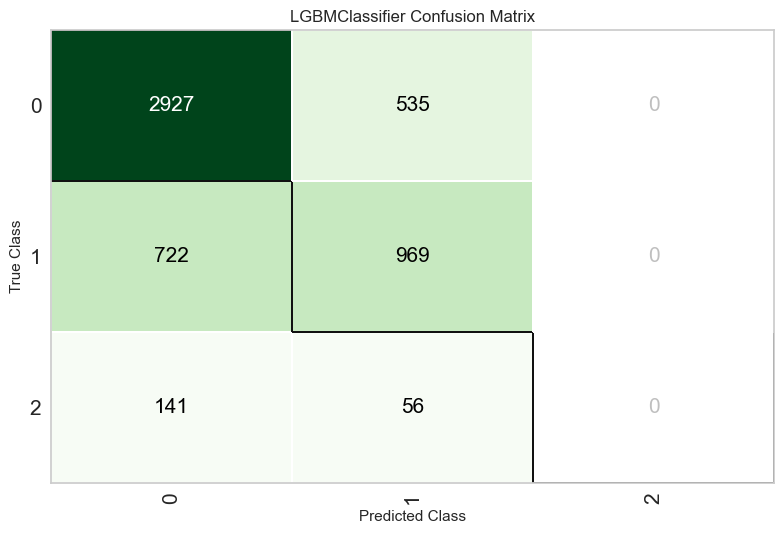

In [411]:
plot_model(tuned_model,plot='confusion_matrix')

In [412]:
predictions = predict_model(f, data=test_data)
accuracy = accuracy_score(predictions['target_direction'], predictions['prediction_label'])
print("Accuracy: {:.2f}%".format(accuracy * 100))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8241,0,0,0,0,0.3378,0.3700


Accuracy: 82.41%


In [413]:
plot_model(f)

ValueError: Number of features of the model must match the input. Model n_features_ is 162 and input n_features is 159

<Figure size 800x550 with 0 Axes>

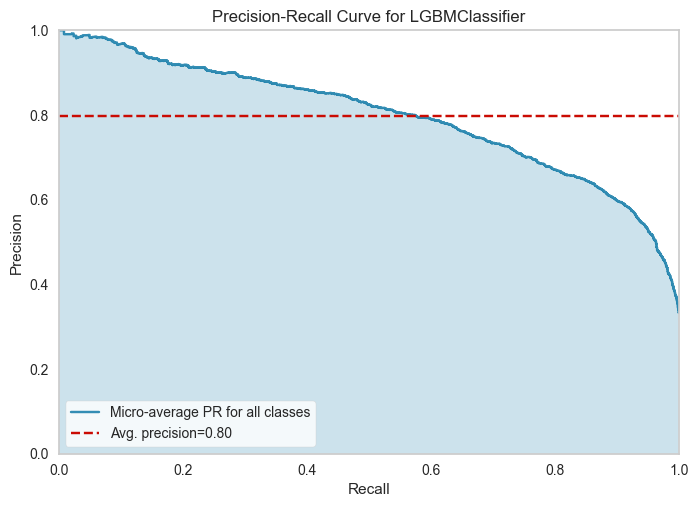

In [414]:
plot_model(f,plot="pr")

In [415]:
plot_model(f,plot="confusion_matrix")

ValueError: Number of features of the model must match the input. Model n_features_ is 162 and input n_features is 159

<Figure size 800x550 with 0 Axes>

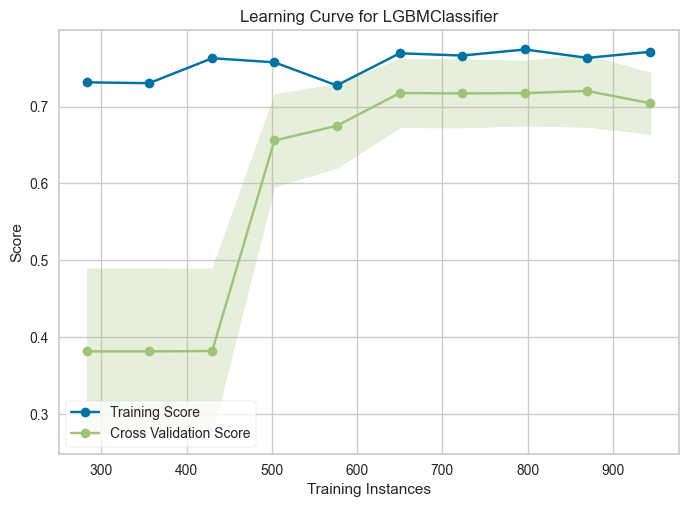

In [416]:
plot_model(tuned_model,plot="learning",use_train_data=False)

In [417]:
plot_model(f,plot="feature",use_train_data=False)

ValueError: All arrays must be of the same length

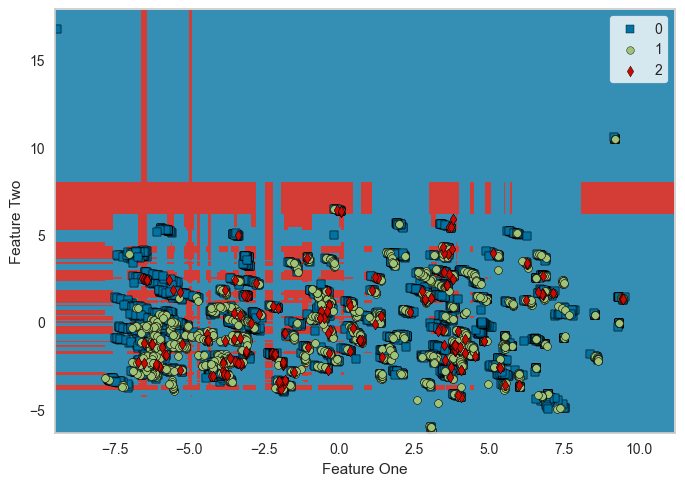

In [418]:
plot_model(f,plot="boundary",use_train_data=False)

In [419]:
def yuzdeler(model, df, prediction_label, y):
    preds = predict_model(model, df)[[y, 'prediction_label', 'prediction_score']]
    son = pd.DataFrame()
    preds = preds[preds['prediction_label']==prediction_label]
    arange = np.arange(0.5, 1, 0.005)
    for i in arange:
        deneme = preds[preds['prediction_score']>=i]
        yuzde = round(accuracy_score(deneme[y], deneme['prediction_label']), 3)
        dicto = {'Thresh': i, 'Yüzde': yuzde, 'Len': len(deneme)}
        son = son.append(pd.DataFrame(dicto, index=[0]), ignore_index=True)
        son = son.dropna(axis=0)
    #son.to_csv(f"precs/{y}model_{prediction_label}.csv", index=False)
    return son.sort_values('Thresh', ascending=False)


In [420]:
predict_model(f, test_data)[["target_direction", 'prediction_label', 'prediction_score']]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8241,0,0,0,0,0.3378,0.3700


,target_direction,prediction_label,prediction_score
34943,ENERGY_SURPLUS,ENERGY_DEFICIT,0.4694
34944,ENERGY_SURPLUS,ENERGY_DEFICIT,0.6401
34945,ENERGY_SURPLUS,ENERGY_DEFICIT,0.6401
34946,ENERGY_SURPLUS,ENERGY_SURPLUS,0.5206
34947,ENERGY_SURPLUS,ENERGY_SURPLUS,0.5248
...,...,...,...
43695,ENERGY_DEFICIT,ENERGY_DEFICIT,0.7096
43696,ENERGY_DEFICIT,ENERGY_DEFICIT,0.6699
43697,ENERGY_SURPLUS,ENERGY_DEFICIT,0.7475
43698,ENERGY_SURPLUS,ENERGY_DEFICIT,0.7466


In [421]:
test_data['target_direction'].unique()

array(['ENERGY_SURPLUS', 'IN_BALANCE', 'ENERGY_DEFICIT'], dtype=object)

In [422]:
p = predict_model(f,data =test_data)

px =p[["date","target_direction",'prediction_label','prediction_score']]


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8241,0,0,0,0,0.3378,0.3700


In [423]:
yuzdeler(f,test_data,"ENERGY_SURPLUS","target_direction").head(50)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8241,0,0,0,0,0.3378,0.3700


,Thresh,Yüzde,Len
41,0.705,1.000,1
40,0.700,1.000,5
39,0.695,0.857,7
38,0.690,0.800,10
37,0.685,0.727,11
36,0.680,0.769,13
35,0.675,0.824,17
34,0.670,0.789,19
33,0.665,0.750,24
32,0.660,0.806,31


### 1 Sınıfı İçin

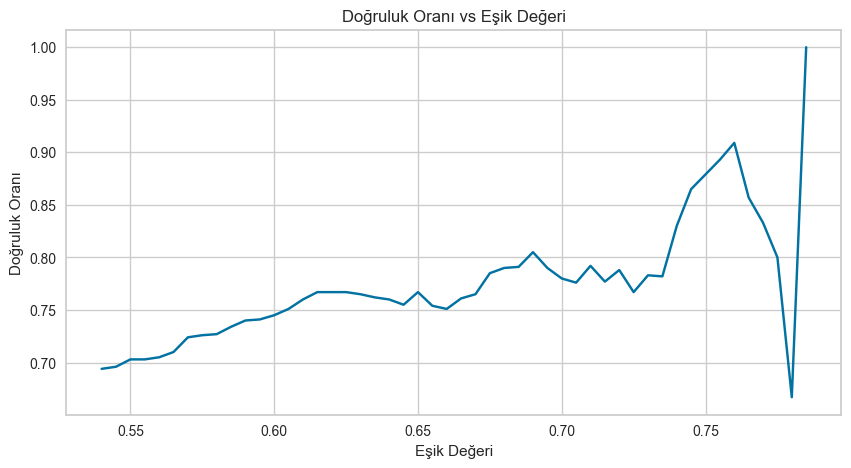

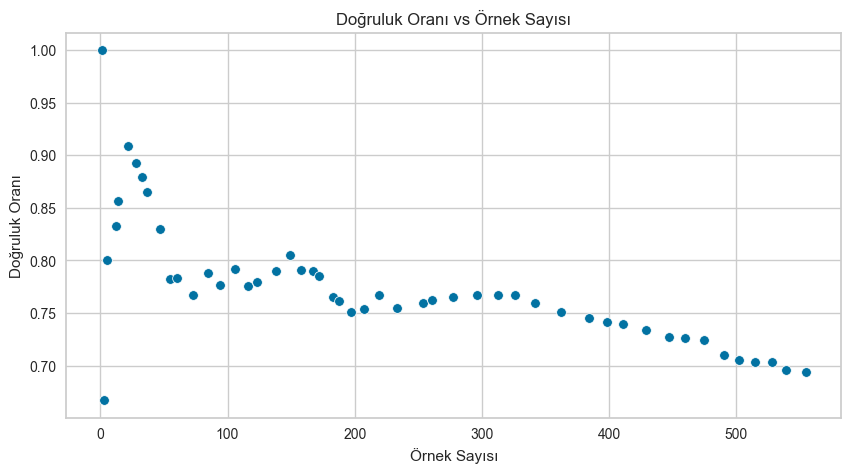

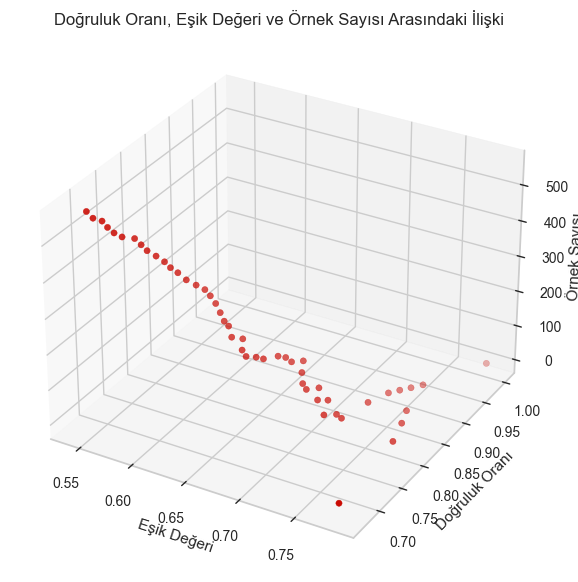

In [348]:
import matplotlib.pyplot as plt
import seaborn as sns

sonuclar = yuzdeler(f,test_data,"ENERGY_SURPLUS","target_direction").head(50)


# Doğruluk oranı (Yüzde) ve Eşik (Thresh) değerlerine göre bir çizgi grafiği oluşturma
plt.figure(figsize=(10, 5))
sns.lineplot(x='Thresh', y='Yüzde', data=sonuclar)
plt.title("Doğruluk Oranı vs Eşik Değeri")
plt.xlabel("Eşik Değeri")
plt.ylabel("Doğruluk Oranı")
plt.show()

# Doğruluk oranı (Yüzde) ve Örnek Sayısı (Len) arasındaki ilişkiyi gösteren bir dağılım grafiği oluşturma
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Len', y='Yüzde', data=sonuclar)
plt.title("Doğruluk Oranı vs Örnek Sayısı")
plt.xlabel("Örnek Sayısı")
plt.ylabel("Doğruluk Oranı")
plt.show()

# Doğruluk oranı (Yüzde), Eşik (Thresh) değeri ve Örnek Sayısı (Len) arasındaki 3D ilişkiyi gösteren bir görsel
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = sonuclar['Thresh']
y = sonuclar['Yüzde']
z = sonuclar['Len']

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel("Eşik Değeri")
ax.set_ylabel("Doğruluk Oranı")
ax.set_zlabel("Örnek Sayısı")
plt.title("Doğruluk Oranı, Eşik Değeri ve Örnek Sayısı Arasındaki İlişki")
plt.show()


import plotly.express as px

fig = px.scatter_3d(sonuclar, x='Thresh', y='Yüzde', z='Len', color='Thresh',
                    labels={'Thresh': 'Eşik Değeri', 'Yüzde': 'Doğruluk Oranı', 'Len': 'Örnek Sayısı'},
                    title="Doğruluk Oranı, Eşik Değeri ve Örnek Sayısı Arasındaki İlişki")

fig.show()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8222,0,0,0,0,0.3213,0.3537


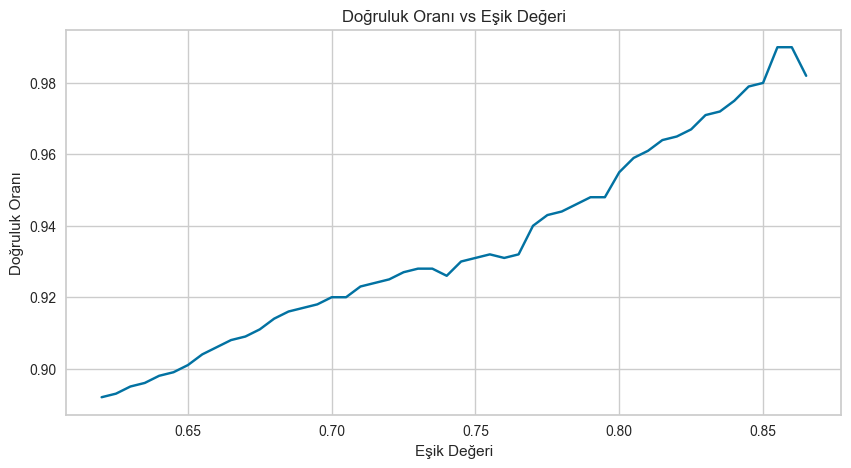

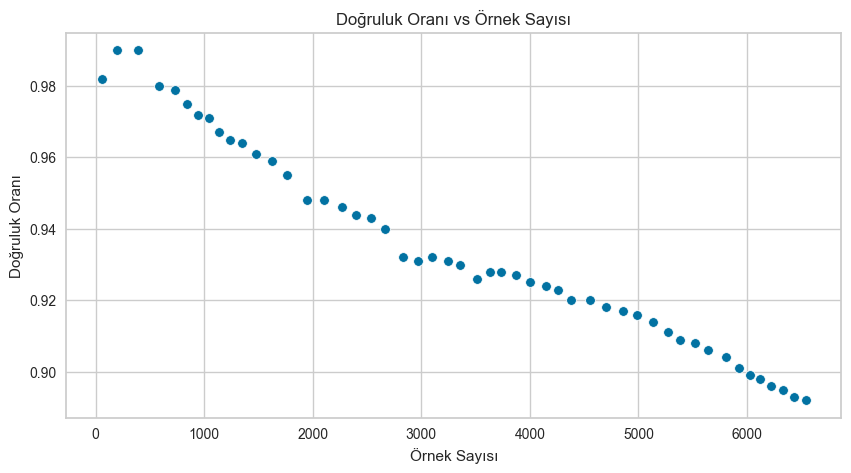

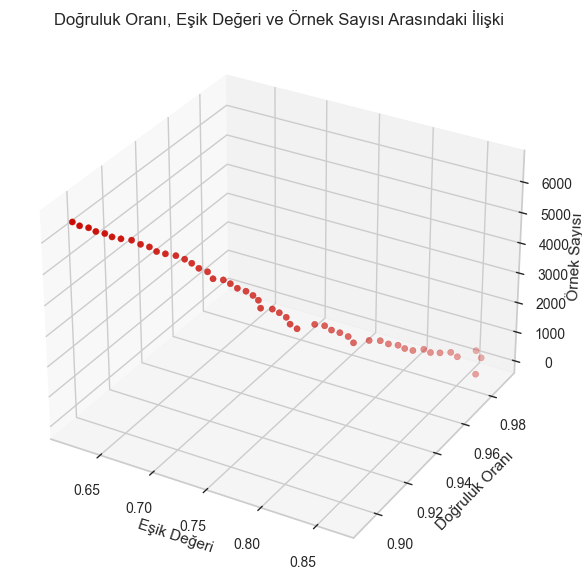

In [349]:
import matplotlib.pyplot as plt
import seaborn as sns

sonuclar = yuzdeler(f,test_data,"ENERGY_DEFICIT","target_direction").head(50)


# Doğruluk oranı (Yüzde) ve Eşik (Thresh) değerlerine göre bir çizgi grafiği oluşturma
plt.figure(figsize=(10, 5))
sns.lineplot(x='Thresh', y='Yüzde', data=sonuclar)
plt.title("Doğruluk Oranı vs Eşik Değeri")
plt.xlabel("Eşik Değeri")
plt.ylabel("Doğruluk Oranı")
plt.show()

# Doğruluk oranı (Yüzde) ve Örnek Sayısı (Len) arasındaki ilişkiyi gösteren bir dağılım grafiği oluşturma
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Len', y='Yüzde', data=sonuclar)
plt.title("Doğruluk Oranı vs Örnek Sayısı")
plt.xlabel("Örnek Sayısı")
plt.ylabel("Doğruluk Oranı")
plt.show()

# Doğruluk oranı (Yüzde), Eşik (Thresh) değeri ve Örnek Sayısı (Len) arasındaki 3D ilişkiyi gösteren bir görsel
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = sonuclar['Thresh']
y = sonuclar['Yüzde']
z = sonuclar['Len']

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel("Eşik Değeri")
ax.set_ylabel("Doğruluk Oranı")
ax.set_zlabel("Örnek Sayısı")
plt.title("Doğruluk Oranı, Eşik Değeri ve Örnek Sayısı Arasındaki İlişki")
plt.show()


import plotly.express as px

fig = px.scatter_3d(sonuclar, x='Thresh', y='Yüzde', z='Len', color='Thresh',
                    labels={'Thresh': 'Eşik Değeri', 'Yüzde': 'Doğruluk Oranı', 'Len': 'Örnek Sayısı'},
                    title="Doğruluk Oranı, Eşik Değeri ve Örnek Sayısı Arasındaki İlişki")

fig.show()
